# Python: Local Potential Quantiles
In this example, we illustrate how the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to estimate local potential quantiles and quantile treatment effects. The estimation is based on the article from [Kallus  et al.](https://arxiv.org/abs/1912.12945)

## Data
We define a data generating process to create synthetic data to compare the estimates to the true effect.

In [1]:
import numpy as np
import pandas as pd
import doubleml as dml
import multiprocessing

from sklearn.ensemble import RandomForestClassifier

The data is generated as a location-scale model with confounding of the treatment $D_i$ and instrument $Z_i$

$$\begin{aligned}
Y_i &= \text{loc}\left(D_i,X_i, X^{(conf)}_i\right) + \text{scale}\left(D_i,X_i, X^{(conf)}_i\right)\cdot\varepsilon_i,\\
D_i &=\bold{1}\{1.5Z_i -0.3X_{i,1}+0.7X^{(conf)}_i + \eta_i > 0\},
\end{aligned}$$

where $X_i\sim\mathcal{U}[0,1]^{p}$, $X^{(conf)}_i \sim\mathcal{U}[-1,1]$, $Z_i\sim \mathcal{B}(1,1/2)$, $\varepsilon_i \sim \mathcal{N}(0,1)$ and $\eta_i \sim \mathcal{N}(0,1)$.
Further, the location and scale are determined according to the following functions

$$\begin{aligned}
\text{location}(d,x, x^{(conf)}) &:= 0.3d + 4dx_3x_1 - 3x_2 - 2x^{(conf)}\\
\text{scale}(d,x, x^{(conf)}) &:= \sqrt{d/2 + 3dx_1 + 0.4x^{(conf)} + 1}
\end{aligned}$$

In [2]:
def f_loc(D, X, X_conf):
  loc = 0.3*D + 4*D*X[:, 2]*2*X[:, 0] - 3*X[:, 1] - 2*X_conf[:, 0]
  return loc

def f_scale(D, X, X_conf):
  scale = np.sqrt(0.5*D + 3*D*X[:, 0] + 0.4*X_conf[:, 0] + 1)
  return scale

def generate_treatment(Z, X, X_conf):
    eta = np.random.normal(size=len(Z))
    d = ((1.5*Z -0.3*X[:, 0] + 0.7*X_conf[:, 0] + eta) > 0)*1.0
    return d

def dgp(n=200, p=5):
    X = np.random.uniform(0, 1, size=[n,p])
    X_conf = np.random.uniform(-1, 1, size=[n,1])
    Z = np.random.binomial(1, p=0.5, size=n) #norm.cdf(3*(1 - X[:, 0] - X[:, 3]))
    D = generate_treatment(Z, X, X_conf)
    epsilon = np.random.normal(size=n)

    Y = f_loc(D, X, X_conf) + f_scale(D, X, X_conf)*epsilon

    return Y, X, D, Z

We can calculate the true potential quantile analytically or through simulations. Here, we will just simulate the true quantile for a range of quantiles.

In [3]:
tau_vec = np.arange(0.1,0.95,0.05)
p = 5
n_true = int(10e+6)

In [4]:
X_true = np.random.uniform(0, 1, size=[n_true,p])
X_conf_true = np.random.uniform(-1, 1, size=[n_true,1])
Z_true = np.random.binomial(1, p=0.5, size=n_true)
eta_true = np.random.normal(size=n_true)
D1_true = generate_treatment(np.ones_like(Z_true), X_true, X_conf_true)
D0_true = generate_treatment(np.zeros_like(Z_true), X_true, X_conf_true)
epsilon_true = np.random.normal(size=n_true)

compliers = (D1_true == 1) * (D0_true == 0)
print(f'Compliance probability: {str(compliers.mean())}')
n_compliers = compliers.sum()
Y1 = f_loc(np.ones(n_compliers), X_true[compliers, :], X_conf_true[compliers, :]) + f_scale(np.ones(n_compliers), X_true[compliers, :], X_conf_true[compliers, :])*epsilon_true[compliers]
Y0 = f_loc(np.zeros(n_compliers), X_true[compliers, :], X_conf_true[compliers, :]) + f_scale(np.zeros(n_compliers), X_true[compliers, :], X_conf_true[compliers, :])*epsilon_true[compliers]

Compliance probability: 0.4851498


In [5]:
Y0_quant = np.quantile(Y0, q=tau_vec)
Y1_quant = np.quantile(Y1, q=tau_vec)

print(f'Local Potential Quantile Y(0): {Y0_quant}')
print(f'Local Potential Quantile Y(1): {Y1_quant}')

Local Potential Quantile Y(0): [-3.55496621 -3.09821849 -2.73475843 -2.42355338 -2.14632248 -1.89078241
 -1.65130275 -1.42191053 -1.19913774 -0.97825451 -0.7570186  -0.53184808
 -0.29752564 -0.04751496  0.22425119  0.53432824  0.90762449]
Local Potential Quantile Y(1): [-2.4173028  -1.80458462 -1.31334923 -0.88555009 -0.49676074 -0.13250331
  0.21752192  0.56020492  0.90400752  1.25206834  1.61419597  1.99557366
  2.4073172   2.86444286  3.39070191  4.01892294  4.8334526 ]


Let us generate $n=10000$ observations and convert them to a [DoubleMLData](https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLData.html) object.

In [6]:
n = 10000
p = 3
Y, X, D, Z = dgp(n=n,p=p)
obj_dml_data = dml.DoubleMLData.from_arrays(X, Y, D, Z)

## Local Potential Quantiles (LPQs)
Next, we can initialize our two machine learning algorithms to train the different classifiers. Then we can initialize the `DoubleMLPQ` objects and call `.fit()` to estimate the relevant parameters. To obtain confidence intervals, we can use the `.confint()` method.

In [7]:
ml_m = RandomForestClassifier(n_estimators=100)

LPQ_0 = np.full((len(tau_vec)), np.nan)
LPQ_1 = np.full((len(tau_vec)), np.nan)

ci_LPQ_0 = np.full((len(tau_vec),2), np.nan)
ci_LPQ_1 = np.full((len(tau_vec),2), np.nan)

for idx_tau, tau in enumerate(tau_vec):
    print(f'Quantile: {tau}')
    dml_LPQ_0 = dml.DoubleMLLPQ(obj_dml_data, ml_m,
                                score="LPQ",
                                treatment=0,
                                quantile=tau,
                                n_folds=5,
                                trimming_threshold=0.05)
    dml_LPQ_1 = dml.DoubleMLLPQ(obj_dml_data,ml_m,
                                score="LPQ",
                                treatment=1,
                                quantile=tau,
                                n_folds=5,
                                trimming_threshold=0.05)

    dml_LPQ_0.fit()
    dml_LPQ_1.fit()

    LPQ_0[idx_tau] = dml_LPQ_0.coef
    LPQ_1[idx_tau] = dml_LPQ_1.coef

    ci_LPQ_0[idx_tau, :] = dml_LPQ_0.confint(level=0.95).to_numpy()
    ci_LPQ_1[idx_tau, :] = dml_LPQ_1.confint(level=0.95).to_numpy()

Quantile: 0.1
Quantile: 0.15000000000000002
Quantile: 0.20000000000000004
Quantile: 0.25000000000000006
Quantile: 0.30000000000000004
Quantile: 0.3500000000000001
Quantile: 0.40000000000000013
Quantile: 0.45000000000000007
Quantile: 0.5000000000000001
Quantile: 0.5500000000000002
Quantile: 0.6000000000000002
Quantile: 0.6500000000000001
Quantile: 0.7000000000000002
Quantile: 0.7500000000000002
Quantile: 0.8000000000000002
Quantile: 0.8500000000000002
Quantile: 0.9000000000000002


Finally, let us take a look at the estimated quantiles.

In [8]:
data = {"Quantile": tau_vec, "Y(0)": Y0_quant, "Y(1)": Y1_quant,
        "DML Y(0)": LPQ_0, "DML Y(1)": LPQ_1,
        "DML Y(0) lower": ci_LPQ_0[:, 0], "DML Y(0) upper": ci_LPQ_0[:, 1],
        "DML Y(1) lower": ci_LPQ_1[:, 0], "DML Y(1) upper": ci_LPQ_1[:, 1]}
df = pd.DataFrame(data)
print(df)

    Quantile      Y(0)      Y(1)  DML Y(0)  DML Y(1)  DML Y(0) lower  \
0       0.10 -3.554966 -2.417303 -3.533184 -2.300373       -3.689361   
1       0.15 -3.098218 -1.804585 -3.075041 -1.725452       -3.223206   
2       0.20 -2.734758 -1.313349 -2.704260 -1.076586       -2.843954   
3       0.25 -2.423553 -0.885550 -2.459876 -0.760462       -2.596315   
4       0.30 -2.146322 -0.496761 -2.171905 -0.462647       -2.311634   
5       0.35 -1.890782 -0.132503 -1.895778 -0.126016       -2.041176   
6       0.40 -1.651303  0.217522 -1.616056  0.290520       -1.761865   
7       0.45 -1.421911  0.560205 -1.393915  0.614740       -1.544667   
8       0.50 -1.199138  0.904008 -1.097608  0.986593       -1.246354   
9       0.55 -0.978255  1.252068 -0.902792  1.408772       -1.053255   
10      0.60 -0.757019  1.614196 -0.716676  1.675611       -0.864563   
11      0.65 -0.531848  1.995574 -0.447942  2.077825       -0.603583   
12      0.70 -0.297526  2.407317 -0.247630  2.580210       -0.41

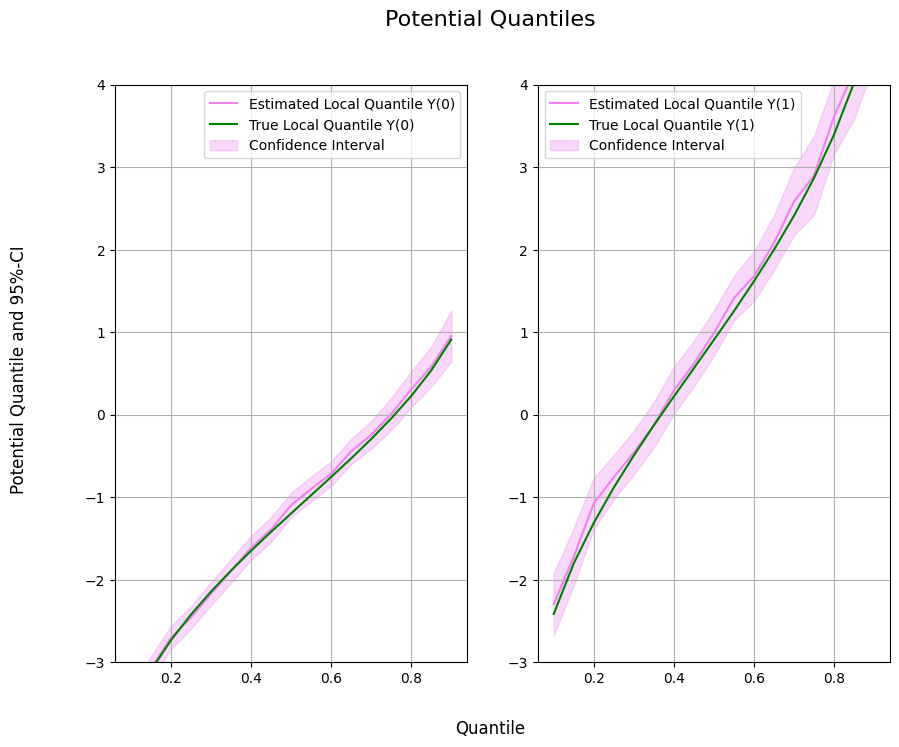

In [9]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10., 7.5
fig, (ax1, ax2) = plt.subplots(1 ,2)
ax1.grid(); ax2.grid()

ax1.plot(df['Quantile'],df['DML Y(0)'], color='violet', label='Estimated Local Quantile Y(0)')
ax1.plot(df['Quantile'],df['Y(0)'], color='green', label='True Local Quantile Y(0)')
ax1.fill_between(df['Quantile'], df['DML Y(0) lower'], df['DML Y(0) upper'], color='violet', alpha=.3, label='Confidence Interval')
ax1.legend()
ax1.set_ylim(-3, 4)

ax2.plot(df['Quantile'],df['DML Y(1)'], color='violet', label='Estimated Local Quantile Y(1)')
ax2.plot(df['Quantile'],df['Y(1)'], color='green', label='True Local Quantile Y(1)')
ax2.fill_between(df['Quantile'], df['DML Y(1) lower'], df['DML Y(1) upper'], color='violet', alpha=.3, label='Confidence Interval')
ax2.legend()
ax2.set_ylim(-3, 4)

fig.suptitle('Potential Quantiles', fontsize=16)
fig.supxlabel('Quantile')
_ = fig.supylabel('Potential Quantile and 95%-CI')

## Local Quantile Treatment Effects (LQTEs)
In most cases, we want to evaluate the (local) treatment effect.
To estimate local quantile treatment effects, we can use the `DoubleMLQTE` object and specify `LPQ` as the score. 

As for quantile treatment effects, different quantiles can be estimated in parallel with `n_jobs_models`.

In [10]:
n_cores = multiprocessing.cpu_count()
print(f"Number of Cores: {n_cores}")

dml_LQTE = dml.DoubleMLQTE(obj_dml_data, 
                           ml_g=ml_m, 
                           quantiles=tau_vec, 
                           score='LPQ', 
                           n_folds=5)
dml_LQTE.fit(n_jobs_models=n_cores-1)
print(dml_LQTE)

Number of Cores: 24
================== DoubleMLQTE Object ==================

------------------ Fit summary       ------------------
          coef   std err          t         P>|t|     2.5 %    97.5 %
0.10  1.297236  0.196270   6.609432  3.857982e-11  0.912553  1.681918
0.15  1.381689  0.179643   7.691307  1.456396e-14  1.029595  1.733783
0.20  1.477077  0.168115   8.786101  1.548402e-18  1.147578  1.806577
0.25  1.670901  0.140661  11.878930  1.523043e-32  1.395211  1.946591
0.30  1.712306  0.144480  11.851504  2.113619e-32  1.429130  1.995481
0.35  1.864888  0.150826  12.364495  4.067575e-35  1.569274  2.160502
0.40  1.817214  0.151271  12.012935  3.038672e-33  1.520728  2.113701
0.45  2.031744  0.144906  14.021123  1.157679e-44  1.747734  2.315755
0.50  2.149987  0.133704  16.080167  3.514311e-58  1.887931  2.412042
0.55  2.262820  0.135965  16.642685  3.419345e-62  1.996334  2.529306
0.60  2.394603  0.138089  17.340982  2.307616e-67  2.123953  2.665253
0.65  2.580958  0.151305  

As for other ``dml`` objects, we can use ``.bootstrap`` and ``.confint`` to generate pointwise confidence intervals or jointly valid confidence intervals.

In [11]:
ci_LQTE = dml_LQTE.confint(level=0.95, joint=False)

dml_LQTE.bootstrap(n_rep_boot=2000)
ci_joint_LQTE = dml_LQTE.confint(level=0.95, joint=True)
ci_joint_LQTE

,2.5 %,97.5 %
0.10,0.750781,1.843690
0.15,0.881528,1.881850
0.20,1.009012,1.945143
0.25,1.279274,2.062528
0.30,1.310045,2.114566
0.35,1.444959,2.284817
0.40,1.396045,2.238383
0.45,1.628298,2.435191
0.50,1.777728,2.522245
0.55,1.884268,2.641373


As before, let us take a look at the estimated effects and confidence intervals.

In [16]:
LQTE = Y1_quant - Y0_quant
data = {"Quantile": tau_vec, "LQTE": LQTE, "DML LQTE": dml_LQTE.coef,
        "DML LQTE pointwise lower": ci_LQTE['2.5 %'], "DML LQTE pointwise upper": ci_LQTE['97.5 %'],
        "DML LQTE joint lower": ci_joint_LQTE['2.5 %'], "DML LQTE joint upper": ci_joint_LQTE['97.5 %']}
df = pd.DataFrame(data)
print(df)

      Quantile      LQTE  DML LQTE  DML LQTE pointwise lower  \
0.10      0.10  1.137663  1.297236                  0.912553   
0.15      0.15  1.293634  1.381689                  1.029595   
0.20      0.20  1.421409  1.477077                  1.147578   
0.25      0.25  1.538003  1.670901                  1.395211   
0.30      0.30  1.649562  1.712306                  1.429130   
0.35      0.35  1.758279  1.864888                  1.569274   
0.40      0.40  1.868825  1.817214                  1.520728   
0.45      0.45  1.982115  2.031744                  1.747734   
0.50      0.50  2.103145  2.149987                  1.887931   
0.55      0.55  2.230323  2.262820                  1.996334   
0.60      0.60  2.371215  2.394603                  2.123953   
0.65      0.65  2.527422  2.580958                  2.284406   
0.70      0.70  2.704843  2.806759                  2.467016   
0.75      0.75  2.911958  3.165512                  2.781030   
0.80      0.80  3.166451  3.248393      

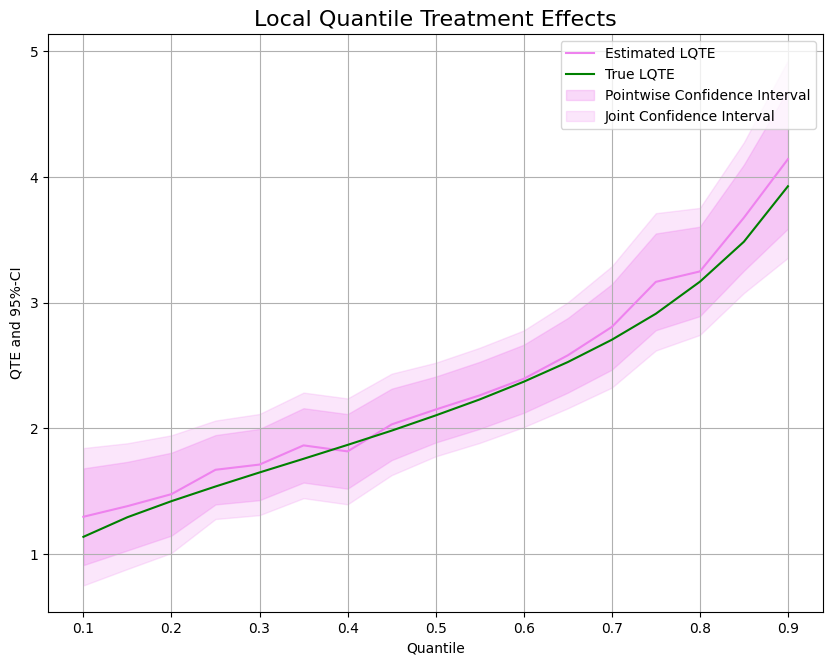

In [17]:
plt.rcParams['figure.figsize'] = 10., 7.5
fig, ax = plt.subplots()
ax.grid()

ax.plot(df['Quantile'],df['DML LQTE'], color='violet', label='Estimated LQTE')
ax.plot(df['Quantile'],df['LQTE'], color='green', label='True LQTE')
ax.fill_between(df['Quantile'], df['DML LQTE pointwise lower'], df['DML LQTE pointwise upper'], color='violet', alpha=.3, label='Pointwise Confidence Interval')
ax.fill_between(df['Quantile'], df['DML LQTE joint lower'], df['DML LQTE joint upper'], color='violet', alpha=.2, label='Joint Confidence Interval')

plt.legend()
plt.title('Local Quantile Treatment Effects', fontsize=16)
plt.xlabel('Quantile')
_ = plt.ylabel('QTE and 95%-CI')